In [1]:
import sys
sys.path.append('..')
import torch
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import StateFn, OperatorStateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliOp, Zero
from qiskit import quantum_info
from qiskit_machine_learning.neural_networks import OpflowQNN

import time

# Related package

import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian related
from openfermion.chem import MolecularData
import openfermion
from openfermionpyscf import run_pyscf

# MISC
r_bohr = 0.529177210903

# Global variable
n_qubits = 4

# 
tolerance = 1e-6
min_pass = 5

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points
# Qiskit instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


In [2]:
def Rot(circ, alpha, beta, theta, qubit):
    circ.rx(alpha, qubit)
    circ.ry(beta, qubit)
    circ.rz(theta, qubit)
# Ansatz
def ansatz(circ, params):
    for i in range(n_qubits):
        print(i)
        Rot(circ, params[i*3+0], params[i*3+1], params[i*3+2], i)
    for j in range(n_qubits-1, -1, -1):
        for k in range(j+1, n_qubits):
            circ.cx(j, k)

In [3]:
# Hamiltonian


def get_H2_hamiltonian(distance):
    bond_length=distance*r_bohr
    geometry = [('H', (0., 0., -bond_length/2)), ('H', (0., 0., bond_length/2))]
    molecule = MolecularData(
        geometry, basis, multiplicity,charge=0,
        description=str(round(bond_length, 2)))
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    terms_molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[], active_indices=[0,1])
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    jw_hamiltonian = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)
#     print(jw_hamiltonian.terms)
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

    return jw_hamiltonian.terms, molecule.fci_energy


In [4]:
# parameters
params_list = []
for idx in range(12):
    params_list.append(Parameter("param_"+str(idx)))

In [5]:


def measurements(gatesPrefix):
    obs = list("IIII")
    for qubit, gatePrefix in list(gatesPrefix):
        obs[n_qubits-qubit-1]=gatePrefix
    return "".join(obs)
def initCircuit(distance):
    H, fci_energy = get_H2_hamiltonian(distance)
    def circuitDefTemplate(params, obsStr):
        ansatz(params)
        return  measurements(obsStr)
    
    qnn_circ = QuantumCircuit(n_qubits, 0)
    ansatz(qnn_circ, params_list)
    
    expval = AerPauliExpectation()
    
    # define gradient method
#     gradient = Gradient(grad_method='param_shift')
    gradient = Gradient(grad_method='fin_diff')
#     gradient=[]
    qc_sfn1 = StateFn(qnn_circ)
    weightList = []
    measList = []
    for i, idx in enumerate(H):
        weightList.append(H[idx].real)
        measList.append(measurements(idx))

    H1 = StateFn(PauliSumOp.from_list(list(zip(measList, weightList))))
    op1 = ~H1 @ qc_sfn1
#     qnn = CircuitQNN(circuit=op1, input_params=[], weight_params=qnn_circ.parameters, gradient=gradient, sampling=False, input_gradients=True, quantum_instance=qi, sparse=False)
    qnn = OpflowQNN(op1, [], qnn_circ.parameters, expval, gradient, qi, input_gradients=False)
    initial_weights = torch.ones(12, requires_grad=True)
    model = TorchConnector(qnn, initial_weights) 
    return model, fci_energy,qnn,initial_weights


In [6]:
import torch.nn as nn

distList = np.arange(0.5,1, 0.5)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


timestamp = np.array([])
error = np.array([])

for distance in distList:
    model, fciE,qnn_circ,initial_weights = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        if epoch%5==0:
            print(epoch, exp.item())
            
            timestamp = np.append(timestamp, time.time()-time_start)
            error = np.append(error, exp.item()-fciE)
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                timestamp = np.append(timestamp, time.time()-time_start)
                error = np.append(error, exp.item()-fciE)
                break
        else:
            count = 0
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()       
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.871524453163147
5 1.64273202419281
10 1.3655438423156738
15 1.3432523012161255
20 1.3567456007003784
25 1.276399850845337
30 1.2854087352752686
35 1.2415566444396973
40 0.6262785792350769
45 -0.22510798275470734
50 -0.3316047191619873
55 -0.295563280582428
60 -0.33493703603744507
65 -0.35668689012527466
70 -0.38248708844184875
75 -0.3968530595302582
80 -0.4081495702266693
85 -0.40240612626075745
90 -0.4071134328842163
95 -0.40949124097824097
100 -0.40975505113601685
105 -0.4097747504711151
110 -0.4105162024497986
115 -0.4105595350265503
120 -0.4105663299560547
125 -0.4107498824596405
130 -0.41072362661361694
135 -0.41075390577316284
140 -0.41076672077178955
145 -0.410776823759079
150 -0.41078275442123413
155 -0.410785049200058
160 -0.41078492999076843
165 -0.41078031063079834
170 -0.4105193018913269
175 -0.39955586194992065
180 -0.403632789850235
185 -0.40905311703

time:  148.304376931


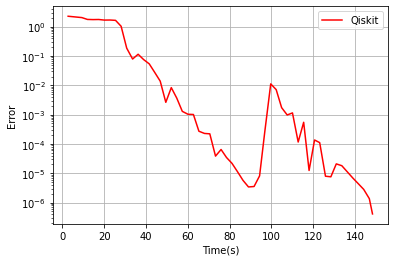

In [7]:
plt.plot(timestamp, error, 'r-', label="Qiskit")
plt.xlabel('Time(s)')
plt.grid()
plt.ylabel('Error')
plt.gca().set_yscale('log')
plt.legend()
print("time: ", time_end-time_start)

In [8]:
import torch.nn as nn

distList = np.arange(0.5,3.5, 0.1)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


for distance in distList:
    time_epoch_start = time.time()
    model, fci_energy,qnn,initial_weights = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>5:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.871524453163147
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0
1
2
3
0 1.4654741287231445
Hartree-Fock energy of -0.837130298190518 Hartree.
Hartree-Fock energy of -0.8463259843661401 Hartree.
0
1
2
3
0 1.1582348346710205
Hartree-Fock energy of -0.9473079310932639 Hartree.
Hartree-Fock energy of -0.9575985319987075 Hartree.
0
1
2
3
0 0.9163154363632202
Hartree-Fock energy of -1.0194970559578667 Hartree.
Hartree-Fock energy of -1.031043026434856 Hartree.
0
1
2
3
0 0.7209731936454773
Hartree-Fock energy of -1.065999462131583 Hartree.
Hartree-Fock energy of -1.0789697691855356 Hartree.
0
1
2
3
0 0.5606570839881897
Hartree-Fock energy of -1.0945640981497409 Hartree.
Hartree-Fock energy of -1.1091

time:  213.548166264


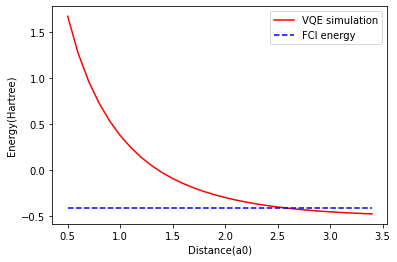

In [9]:
plt.plot(distList, energyList, 'r-', label="VQE simulation")
plt.plot(distList, fciEnergyList, 'b--', label="FCI energy")
plt.xlabel('Distance(a0)')

plt.ylabel('Energy(Hartree)')
plt.legend()
print("time: ", time_end-time_start)

In [10]:
import torch.nn as nn

distList = np.arange(0.5,3.5, 0.1)
energyList_1 = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


for distance in distList:
    time_epoch_start = time.time()
    model, fci_energy,qnn, initial_weights = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>30:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList_1 = np.append(energyList_1, exp.item())
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.871524453163147
5 1.64273202419281
10 1.3655438423156738
15 1.3432523012161255
20 1.3567456007003784
25 1.276399850845337
30 1.2854087352752686
35 1.2415566444396973
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0
1
2
3
0 1.4654741287231445
5 1.2403143644332886
10 0.979036808013916
15 0.9550470113754272
20 0.9712774753570557
25 0.9138856530189514
30 0.9042162895202637
35 0.8169705271720886
40 0.7788750529289246
Hartree-Fock energy of -0.837130298190518 Hartree.
Hartree-Fock energy of -0.8463259843661401 Hartree.
0
1
2
3
0 1.1582348346710205
5 0.9366676211357117
10 0.6910312175750732
15 0.6653332710266113
20 0.6823087334632874
25 0.6409618258476257
30 0.620537281036377
35 0.6031875610351562
Har

0 -0.3086060583591461
5 -0.4831943213939667
10 -0.5407055020332336
15 -0.5777577757835388
20 -0.5853191614151001
25 -0.5829090476036072
30 -0.5855591893196106
35 -0.5868757963180542
40 -0.5876044034957886
45 -0.6978652477264404
Hartree-Fock energy of -0.8852750001255916 Hartree.
Hartree-Fock energy of -0.985156824374877 Hartree.
0
1
2
3
0 -0.3180813193321228
5 -0.49156543612480164
10 -0.5462534427642822
15 -0.5806897282600403
20 -0.5895199775695801
25 -0.5871618986129761
30 -0.5889148712158203
35 -0.5905474424362183
40 -0.5907598733901978
45 -0.5910794138908386
Hartree-Fock energy of -0.870429788406518 Hartree.
Hartree-Fock energy of -0.9782910065654862 Hartree.
0
1
2
3
0 -0.32648053765296936
5 -0.4988934397697449
10 -0.5509059429168701
15 -0.582650363445282
20 -0.5929222702980042
25 -0.5907736420631409
30 -0.5913557410240173
35 -0.5934701561927795
40 -0.5935766696929932
Hartree-Fock energy of -0.8560969196807475 Hartree.
Hartree-Fock energy of -0.9721473744174565 Hartree.
0
1
2
3
0 -0

In [11]:
np.savez('vqe_qiskit.npz', t=timestamp, e=error, d=distList, el=energyList, el1=energyList_1, rel=fciEnergyList)

In [ ]:
import torch.nn as nn

distList = np.arange(0.5,3.5, 0.1)
energyList_2 = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


for distance in distList:
    time_epoch_start = time.time()
    model, fci_energy,qnn, initial_weights = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>180:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList_1 = np.append(energyList_1, exp.item())
time_end = time.time()

##### 